## Diamond Pricing Analysis and Prediction

### Introduction

_As a Data Analyst, my objective in this project is to assist an online jewelry retailer in developing a more efficient approach to pricing newly acquired diamonds. With thousands of diamonds requiring pricing each day, the company is seeking a cost-effective and scalable pricing model that can support experts in making fast and consistent pricing decisions._

_To achieve this, I am working with a dataset of historical diamond sales to uncover pricing patterns and build a predictive model. The goal is to estimate prices accurately based on key diamond features such as carat, cut, color, and clarity. By automating the initial price estimation process, this model enables pricing specialists to work more efficiently&ndash;reducing manual effort while maintaining accuracy and speed in daily operations._

_Diamonds are evaluated based on a set of core characteristics known as the four **C**'s: **_cut_**, **_color_**, **_clarity_**, and **_carat_**. **_Cut_** refers to the quality of a diamond's form. Well-cut diamonds are symmetrical and reflect light well, giving them a sparkly appearance. **_Color_** is the color of the stone. The clearer the diamond, the higher its color grade. Yellower diamonds are less valuable. **_Clarity_** refers to the number of imperfections on the surface of the stone or within it. Clearer diamonds are more valuable. **_Carat_** is a measure of weight used for gems. A one-carat round-cut diamond is about the size of a green pea. The term carat actually comes from the carob seed, which was historically used to weigh precious stones._

The features in the dataset include:

| Column    | Description                                                                         |
| --------- | ----------------------------------------------------------------------------------- |
| `carat`   | Weight of the diamond (in **metric carats**, where 1 carat = 0.2 grams)             |
| `cut`     | Quality of the cut (categorical: **Fair, Good, Very Good, Premium, Ideal**)         |
| `color`   | Diamond color (categorical: from **D** (best) to **J** (worst))                     |
| `clarity` | Clarity of the diamond (categorical: from **IF** (flawless) to **I1** (inclusions)) |
| `depth`   | Total depth percentage = `z / mean(x, y)` (as a % of width)                         |
| `table`   | Width of the top of the diamond relative to its widest point                        |
| `price`   | Price in US dollars                                                                 |
| `x`       | Length of the diamond when viewed face-up                                           |  
| `y`       | Width of the diamond when viewed face-up                                            |
| `z`       | Height of the diamond when standing on its point.                                   |


### 1. Imports and Data Loading

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.patches as patches
from matplotlib.ticker import AutoMinorLocator, NullFormatter

In [113]:
df = pd.read_csv("diamonds_dataset.csv")

In [114]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


### 2. Exploratory Analysis

In [115]:
df.describe()

,carat,depth,table,price,x,y,z
count,53941.000000,53941.000000,53941.000000,53941.000000,53941.000000,53941.000000,53941.000000
mean,0.797953,61.749447,57.457231,3932.885875,5.731183,5.734554,3.538753
std,0.474016,1.432641,2.234497,3989.452937,1.121767,1.142143,0.705707
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5325.000000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


+ The dataset contains almost 54,000 rows, which is an excellent amount of data to work with to create an accurate estimate of the population of diamonds.
+ The mean price is approximately `$4,000` and the largest diamond weighs around 5 carats, which is considered quite large. This may correspond to the diamond priced at `$18,000`.

In [116]:
# Estimate mean price of diamonds by cut
df.groupby(["cut"])[["price"]].mean()

,price
cut,
Fair,4358.757764
Good,3929.812309
Ideal,3457.541970
Premium,4584.257704
Very Good,3981.759891


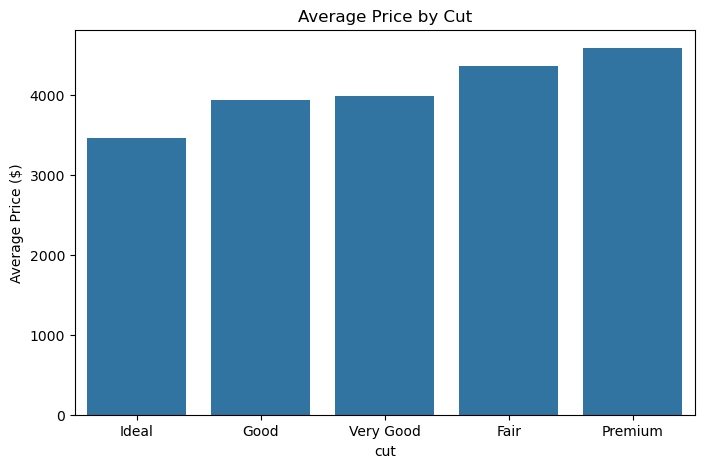

In [158]:
# Group and sort
grouped_df = df.groupby("cut")["price"].mean().sort_values().reset_index()

# Plot with seaborn
plt.figure(figsize=(8,5))
sns.barplot(data=grouped_df, x="cut", y="price", color="C0")

plt.title("Average Price by Cut")
plt.ylabel("Average Price ($)")
plt.xticks(rotation=0)
plt.show()

+ From the above plot, the distribution seems a bit odd to me. I did not expect `Fair` cut diamonds to be, on average, more expensive than `Ideal` cut ones.

+ Also, `Good` and `Very Good` cut diamonds appear to have quite similar prices. A two-sample t-test can be used to determine whether this similarity is statistically significant. But before that, to better set my expectations, it seems appropriate to first use boxplots to visualize the distribution of prices based on the cut.

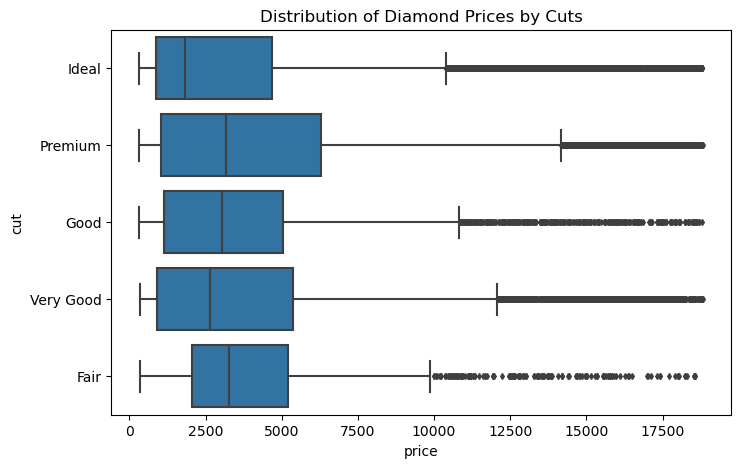

In [119]:
# Boxplots of diamond prices by cuts
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x="price", y="cut",fliersize=3, color="C0")
plt.title("Distribution of Diamond Prices by Cuts")
plt.show()

+ The boxplots show that the median values for `Good` and `Very Good` cut diamonds are different, and that `Very Good` diamonds have a larger interquartile range, suggesting potentially higher variability. However, it's not clear whether the mean price differs significantly between the two categories.

+ To test this difference, we will conduct a two-sample  t-test in one of the next steps.

In [160]:
print(pd.unique(df["clarity"].sort_values()))

['I1' 'IF' 'SI1' 'SI2' 'VS1' 'VS2' 'VVS1' 'VVS2']


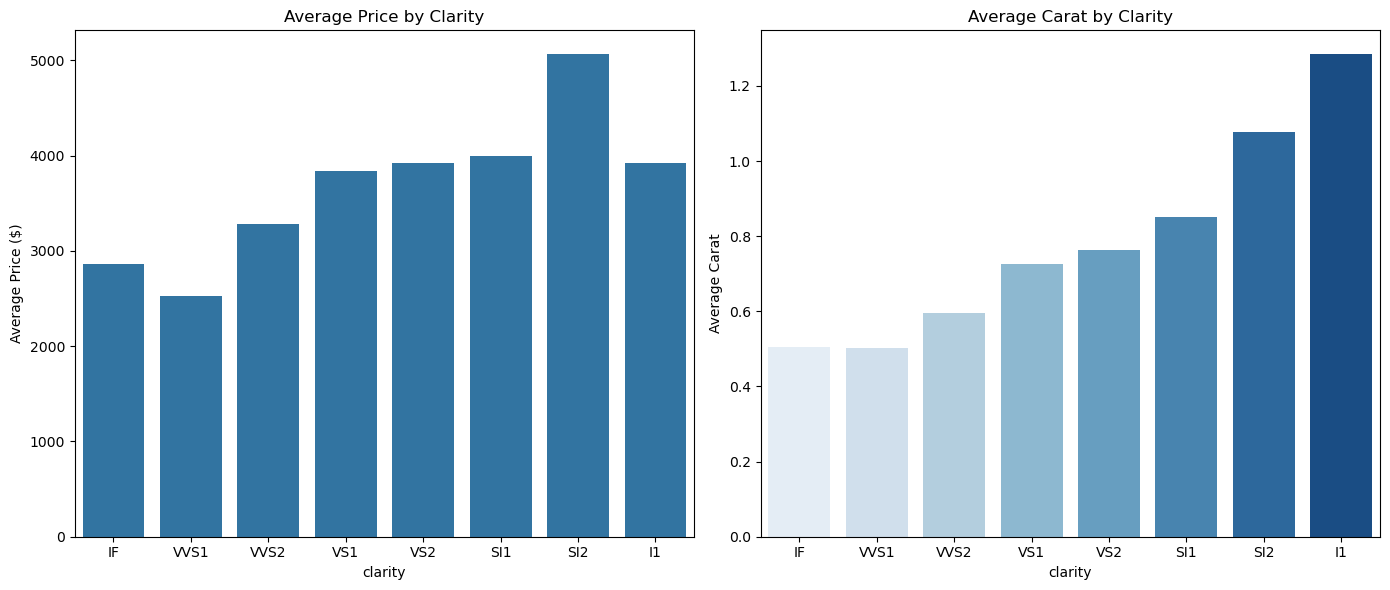

In [174]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Group and sort by clarity and price
grouped_df = df.groupby("clarity")["price"].mean().sort_values().reset_index()

# Define clarity order
clarity_order = ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"]

# Barplot of Average Price by Clarity
sns.barplot(data=grouped_df, x="clarity", y="price",
            color="C0", order=clarity_order, ax=axes[0])
axes[0].set_title("Average Price by Clarity")
axes[0].set_ylabel("Average Price ($)")
plt.xticks(rotation=0)

# Group and sort by clarity and carat
grouped_df = df.groupby("clarity")["carat"].mean().reindex(clarity_order).reset_index()

# Barplot of Average Carat by Clarity
sns.barplot(data=grouped_df, x="clarity", y="carat", 
            palette="Blues", order=clarity_order, ax=axes[1])
axes[1].set_title("Average Carat by Clarity")
axes[1].set_ylabel("Average Carat")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

At first glance, the _`Average Price by Clarity`_ bar plot appears counterintuitive. We would normally expect diamonds with higher `clarity` grades such as `IF`, `VVS1`, `VVS2` to be more expensive than those with lower `clarity` grades like `SI2` or `I1`. However, the plot shows that diamonds with lower `clarity` grades have higher average prices. Surprisingly, `SI2`, a relatively low clarity grade, shows the highest average price.

The _`Average Carat by Clarity`_ bar plot provides a possible explanation. It reveals that diamonds with lower `clarity` grades tend to have larger `carat` sizes on average. This makes sense because larger diamonds are rarer, and `clarity` flaws are harder to avoid at larger sizes, which often results in high-carat diamonds of lower `clarity` grades. This suggests that `carat` weight might have much stronger influence on `price` than `clarity`.

This observation will further be investigated in the next steps of the analysis.

### 3. Statistical Analysis

Next, I am interested in comparing the average prices across different diamond cuts. This analysis will help the client better understand how pricing varies by cut. This will enable more targeted marketing strategies for different customer segments.

To investigate this, a two-sample t-test will be conducted to determine whether two groups of diamonds, in particular, `Good` and `Very Good`, have significantly different prices on average.

The assumption here is that these two groups of diamonds: `Good` and `Very Good` are from two completely independent distributions. This is a valid assumption because there is no known relationship between a diamond in the `Very Good` subset and a diamond in the `Good` subset.

In [120]:
# Conduct a two-sample t-test
very_good = df[df["cut"] == "Very Good"]["price"]
good = df[df["cut"] == "Good"]["price"]
test_results = stats.ttest_ind(very_good, good)
test_results

Ttest_indResult(statistic=0.7941427626594914, pvalue=0.4271234189400054)

In [121]:
if test_results[1] > 0.05:
    print("Failed to reject the null hypothesis with p-value", test_results[1])
else:
    print("Rejected the null hypothesis with p-value", test_results[1])

Failed to reject the null hypothesis with p-value 0.4271234189400054


This is a useful conclusion, and this test might help the client develop a similar pricing and marketing strategy for both `Good` and `Very Good` cut diamonds.

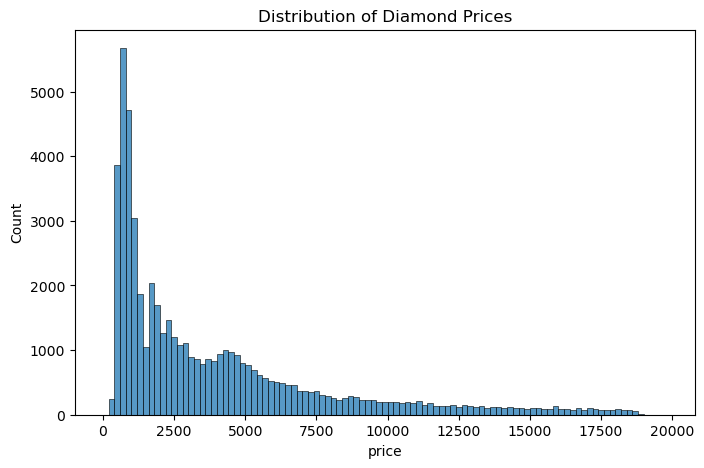

In [122]:
# Create a histogram of the prices of diamonds
plt.figure(figsize=(8,5))
ax=sns.histplot(df, x="price", bins = range(0,20000,200))
plt.title("Distribution of Diamond Prices")
plt.show()

+ The distribution is quite positively skewed which makes sense given that more expensive diamonds are relatively rare. However, despite the skewness of this distribution, the sampling distribution of the mean is expected to be normal due to the central limit theorem. Therefore, using a confidence interval is appropriate in this case.

In [123]:
# Confidence interval for mean diamond price

# Variables for sample size(n), sample mean(xbar), standard deviation(s) and confidence interval(CI)
n = df["price"].count()
xbar = df["price"].mean()
s = df["price"].std()
conf = 0.95

# standard error of the mean
SEM = s / np.sqrt(n)
print(SEM)

# Calculate confidence interval
interval = stats.norm.interval(confidence=conf, loc=xbar, scale=SEM)
print(interval)

17.177258420096
(3899.219067451682, 3966.5526831647326)


+ Even though the mean price is around $3,900, the standard error is quite small, only around 17. This is, partly, because the sample size is so large, which narrows the estimate.
+ With a `95%` confidence, the true mean diamond price is between `$3,899` and `$3,967`. 

#### Regression Analysis

Next, to predict a reasonable market price for each diamond based on its characteristics such as size, cut, and clarity, a different approach is needed, since neither a confidence interval nor a hypothesis test is appropriate for this task.

The goal here is to predict the price of individual diamonds, and not just to perform inference on the overall population. While it's generally known that larger diamonds tend to be more valuable, the key questions are: _`By how much? And which has a greater impact on price`&ndash;`cut or clarity?`_

The plan is to begin with a simple model using a single predictor to estimate diamond price, then gradually include more features.

Linear regression is a useful tool for quantifying relationships between variables. With regression, we can go beyond simply observing that bigger diamonds are associated with higher prices; we can make specific statements such as: _`one-carat increase corresponds to a $10,000 increase in price, all else being equal,`_ or _`a half carat diamond is estimated to cost $7,000`._

In [124]:
# Numeric columns of interest
columns = ["carat", "depth", "table", "x", "y", "z", "price"]

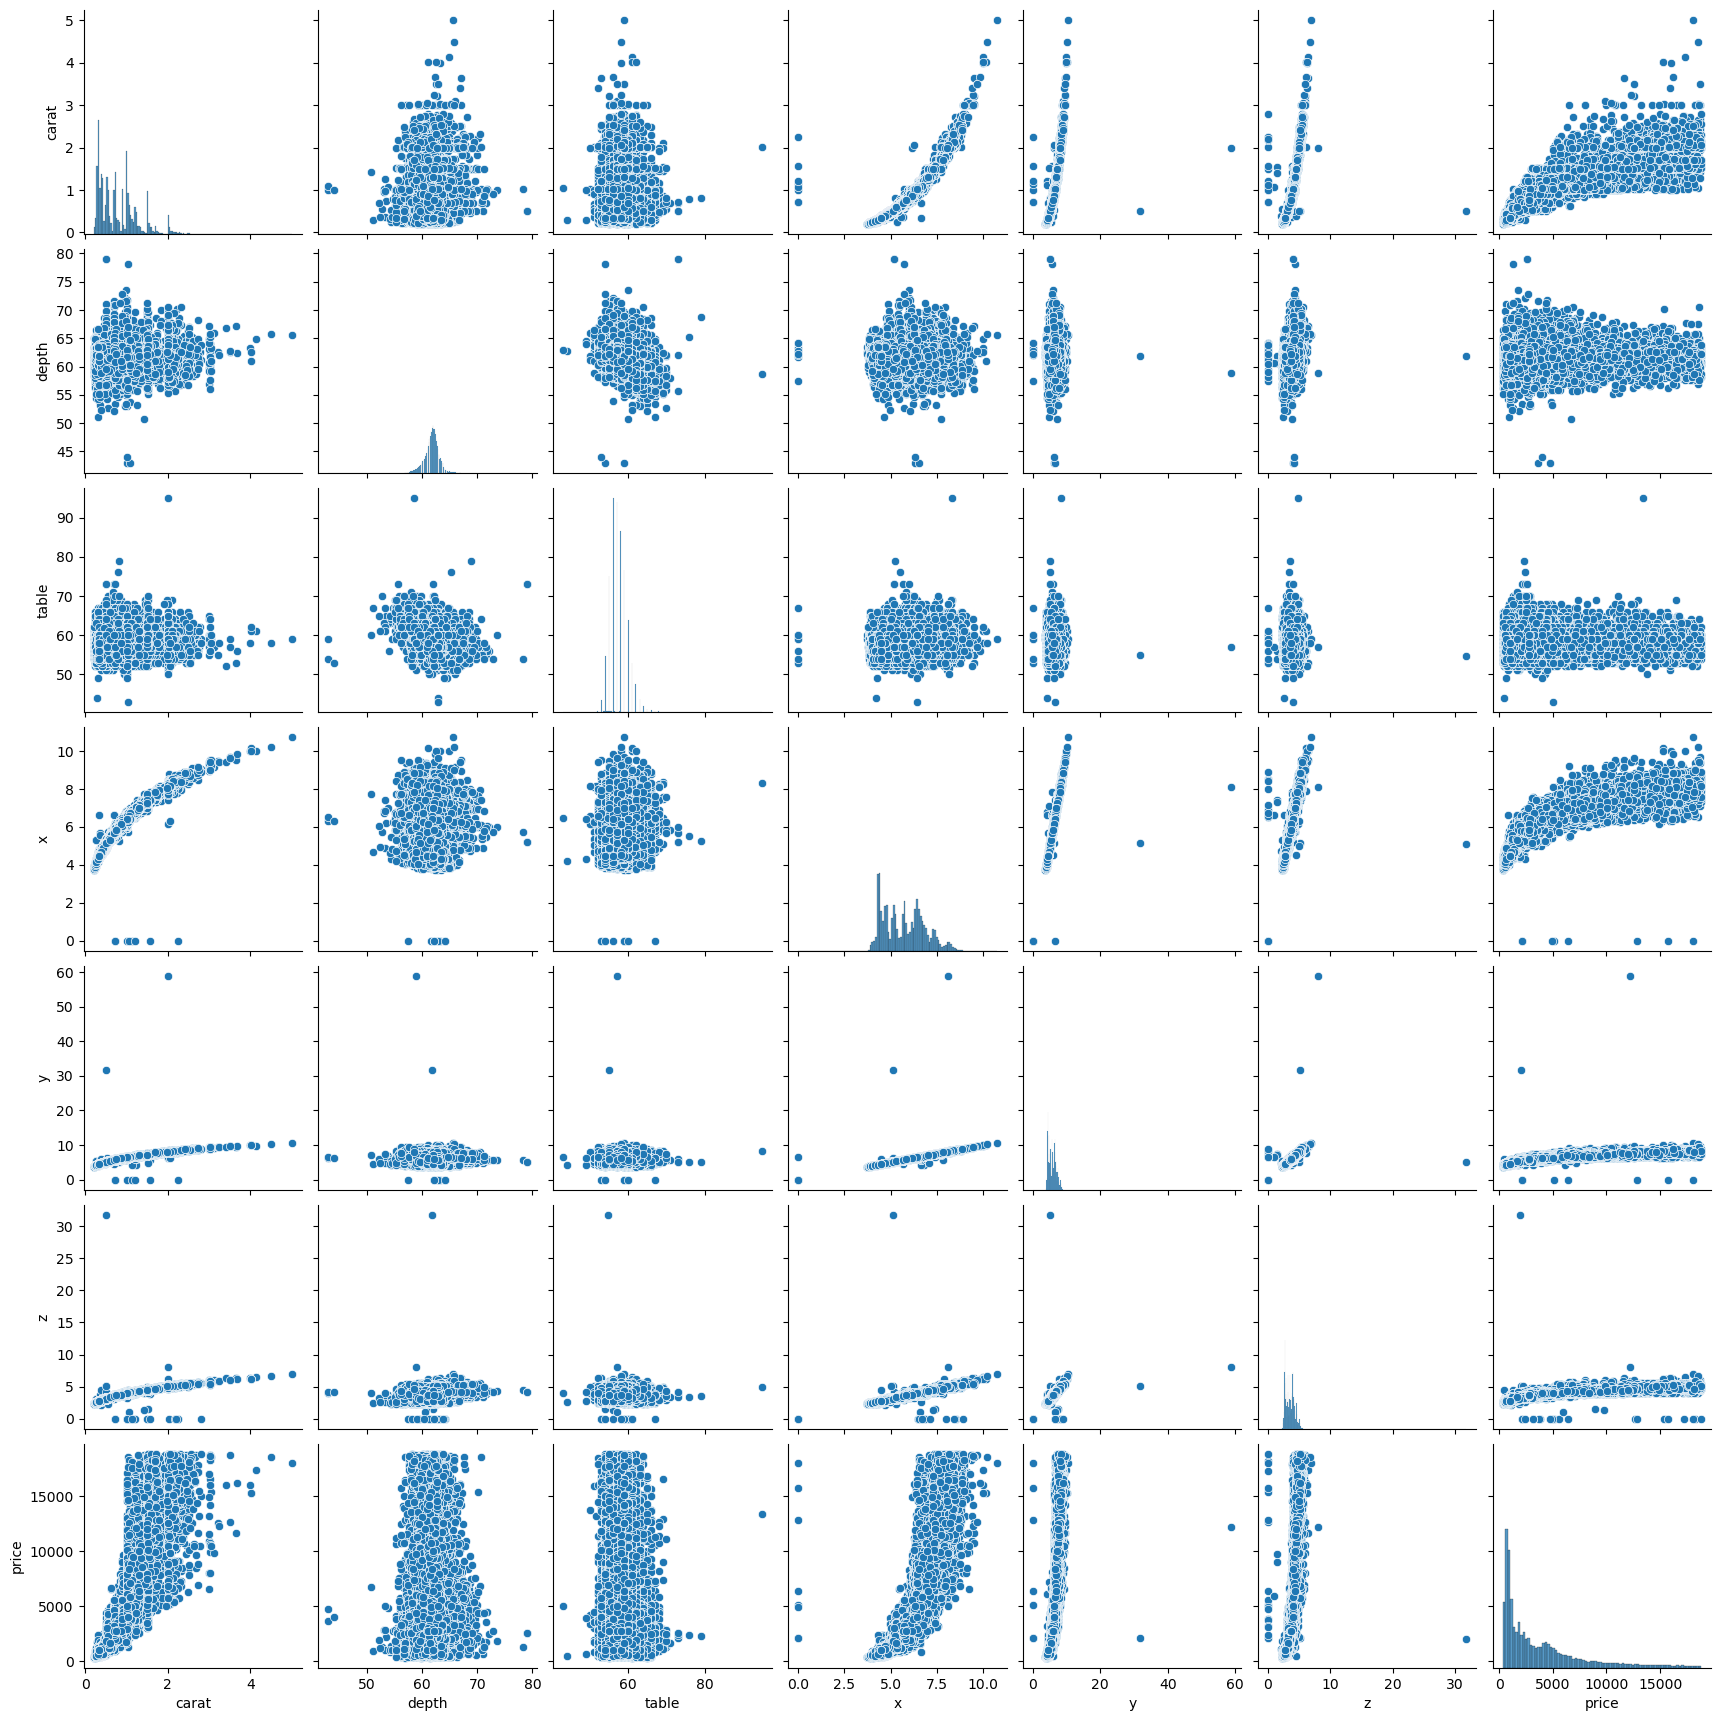

In [125]:
# Examine correlations and scatterplots
sns.pairplot(df[columns])
plt.show()

From the plot, `depth` and `table` don't seem to have a strong relationship with `price` since a line through each of the scatterplots is relatively vertical. However, `price` tends to increase with each of `carat`, `x`, `y` and `z`, suggesting that these variables may be stronger predictors. 

To determine which of these is the most effective independent variable, we will perform a correlation analysis. This will help us quantify the strength of each relationship, and in other words, the predictive power of each feature.

In [126]:
# Examine correlation of the independent variables
df[columns].corr()

,carat,depth,table,x,y,z,price
carat,1.000000,0.028266,0.181643,0.975095,0.951724,0.953389,0.921593
depth,0.028266,1.000000,-0.295735,-0.025252,-0.029301,0.094964,-0.010613
table,0.181643,-0.295735,1.000000,0.195365,0.183783,0.150955,0.127155
x,0.975095,-0.025252,0.195365,1.000000,0.974702,0.970772,0.884438
y,0.951724,-0.029301,0.183783,0.974702,1.000000,0.952007,0.865425
z,0.953389,0.094964,0.150955,0.970772,0.952007,1.000000,0.861253
price,0.921593,-0.010613,0.127155,0.884438,0.865425,0.861253,1.000000


While `x`, `y`, and `z` are strongly correlated with `price`, `carat` shows the strongest correlation among these variables. Based on the correlation values, we can say that a diamond's `carat` explains approximately 92% of the variability in its `price`.

To further investigate this relationship, we will generate a scatterplot of `carat` versus `price`.

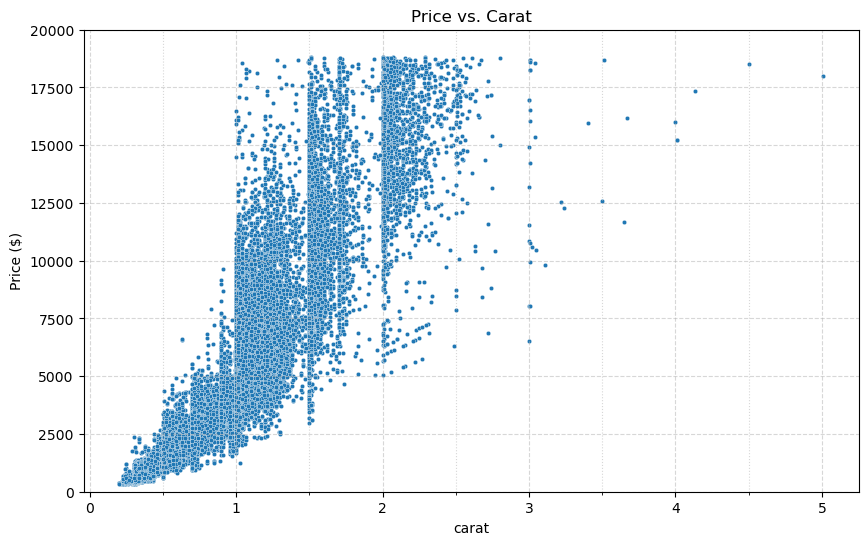

In [198]:
# Scatterplot of price vs. carat
plt.figure(figsize=(10,6))
ax=sns.scatterplot(
    data=df, x="carat", y="price", s=10, marker="o"
)

plt.ylabel("Price ($)")
plt.title("Price vs. Carat")
plt.ylim(0, 20000)

# Grids
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.grid(which="minor", axis="x", linestyle=":", alpha=0.5)

# Only x-axis minor ticks (no labels)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_formatter(NullFormatter())

plt.show()

The scatter plot above shows a clear positive relationship between `carat` and `price`&mdash; as `carat` increases, `price`rises significantly. Even though the relationship appears somewhat non-linear&mdash;especially for larger diamonds&mdash; a linear regression can still be used to model the data fairly accurately, since the linear correlation between these two features is quite strong.

### 4. Model Building and Training

Building and training a model involve identifying the most relevant independent variable(s) and determining the equation of the line of best fit for the data. The trained model can then identify the optimal slope and intercept that best represent the relationship within the data.

In [128]:
# Create the dependent and independent variables
Y = df["price"]
X = sm.add_constant(df["carat"])
# Building and fitting the model
model = sm.OLS(Y, X)
results = model.fit()

In [129]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 3.041e+05
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:15:46   Log-Likelihood:            -4.7274e+05
No. Observations:               53941   AIC:                         9.455e+05
Df Residuals:                   53939   BIC:                         9.455e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2256.3385     13.055   -172.831      0.0

The **_R-squared_** value indicates how well the independent variable (`carat`) explains the variability in the dependent variable (`price`). A high R-squared value means that the independent variable accounts for most of the variation in the dependent variable. In this case, an R-squared of **0.849** is quite high, suggesting that `carat` explains approximately **85%** of the variability in diamond `price`.

**_P-values_**, on the other hand, help determine whether model's coefficients are statistically significant. Using a **95%** confidence level (alpha = **0.05**), the very small p-values for both coefficients indicate a strong statistical significance. Since they are well below 0.05, we can conclude that `carat` is an effective predictor of price of a diamond.

The coefficient for `carat` is **7756**, which means that for every additional `carat`, the model predicts an increase in price of about **`$7,756`**, all other factors being equal.

In summary, the high R-squared value suggests a good overall fit, and the coefficient for `carat` shows a strong, positive, and significant impact on `price`.

In [130]:
# Equation of line of best fit -> price = m*carat + b
results.params

const   -2256.338481
carat    7756.379377
dtype: float64

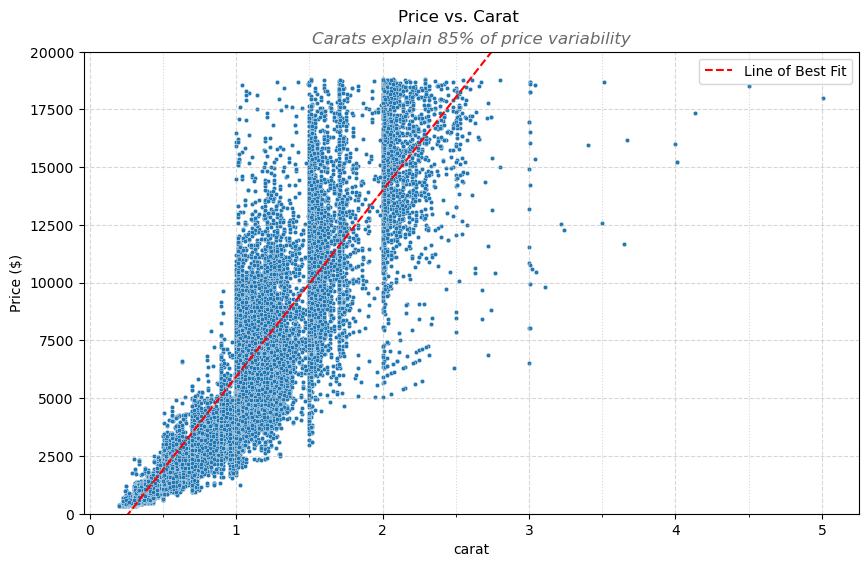

In [146]:
# Get model params
m = results.params["carat"]
b = results.params["const"]

plt.figure(figsize=(10,6))

# Scatter plot (instead of regplot, so seaborn doesn’t refit the line)
sns.scatterplot(
    data=df, x="carat", y="price", s=10, marker="o"
)

# Line of best fit from your model
line = m * df["carat"] + b
sns.lineplot(x=df["carat"], y=line, color="red", ls="--", label="Line of Best Fit")

# Labels & title
plt.ylabel("Price ($)")
plt.suptitle("Price vs. Carat", y=0.95)
plt.title("Carats explain 85% of price variability", color="dimgray", style="italic")
plt.ylim(0, 20000)

# Major & minor grids (x-axis only for minor)
plt.grid(which="major", linestyle="--", alpha=0.5)
plt.grid(which="minor", axis="x", linestyle=":", alpha=0.5)

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.xaxis.set_minor_formatter(NullFormatter())  # hide labels on minor ticks

plt.legend()
plt.show()

From the line of best fit, it can be observed that the majority of the data falls between **0.5** and **2.5** carats. This also appears to be the range in which the model performs best. Specifically, for diamonds with a `carat` of 3, the actual prices vary widely, and the model does not predict those prices accurately. Knowing this limitation can help us adjust our simulations to focus only on diamonds between 0.5 and 2.5 carats. That way, we stay within the range where the model performs most reliably.

With this limitation in mind, the company can use the model as a starting point to estimate prices, speeding up the process for experts by giving them a general baseline to work from.

#### Multiple Linear Regression

Expanding the model beyond a single independent variable leads to a multiple linear regression, which often results in significantly improved predictive performance.

In addition to `carat`, features such as the diamond's dimensions (`x`, `y`, `z`), `cut`, and `color` may provide additional accuracy for the model. These features capture aspects of a diamond's quality and style that can influence `price` in ways not fully explained by `carat` alone.

In [132]:
# Multiple linear regression model
predictors =["carat","x","y","z"]
Y = df["price"]
X = sm.add_constant(df[predictors])
model = sm.OLS(Y, X)
results = model.fit()

In [133]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                 7.892e+04
Date:                Mon, 06 Oct 2025   Prob (F-statistic):               0.00
Time:                        20:16:06   Log-Likelihood:            -4.7188e+05
No. Observations:               53941   AIC:                         9.438e+05
Df Residuals:                   53936   BIC:                         9.438e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1921.0000    104.372     18.405      0.0

The `R-squared` of `0.854` for this model is only a tenth of a percent improvement on the simple model that only used `carat`. It seems that adding more features does help us predict the price of the diamond just a little better than we could do with `carat` alone. Also, the `p-values` suggest that each of the predictors are significant.

In [134]:
# Using our model to predict the price of diamond at index 20107, for example
df.loc[20107]

carat       1.5
cut        Good
color         I
clarity     SI1
depth      64.0
table      60.0
price      8580
x          7.13
y          7.25
z           4.6
Name: 20107, dtype: object

In [135]:
carat = 1.5
x = 7.13
y = 7.25
z = 4.6

m1 = results.params["carat"]
m2 = results.params["x"]
m3 = results.params["y"]
m4 = results.params["z"]
b = results.params["const"]

price = m1*carat + m2*x + m3*y + m4*z + b

print(price)

9520.783644767644


The actual price of this diamond is `$8,580`, while the predicted price is `$9,521`. The prediction for this particular diamond was not very accurate, but building a regression model is an iterative process that involves multiple experiments to improve its performance over time.

#### Encoding categorical variables

We can add categorical features to a model to help improve its performance. However, additional preprocessing steps are needed to get them into a numeric form accepted by the `sm.OLS(Y, X)` function.

`color` seems like a potentially useful independent variable, as it may provide more additive predictive power than variables like `x`, `y` and `z` which may be redundant with `carat`.

In [136]:
print(pd.unique(df["color"].sort_values()))

['D' 'E' 'F' 'G' 'H' 'I' 'J']


The unique colors in this dataset are from `D` to `J`. `D` is a colorless diamond, and represents the best possible value. Diamonds get progressively more yellow moving from `D` to `J`.

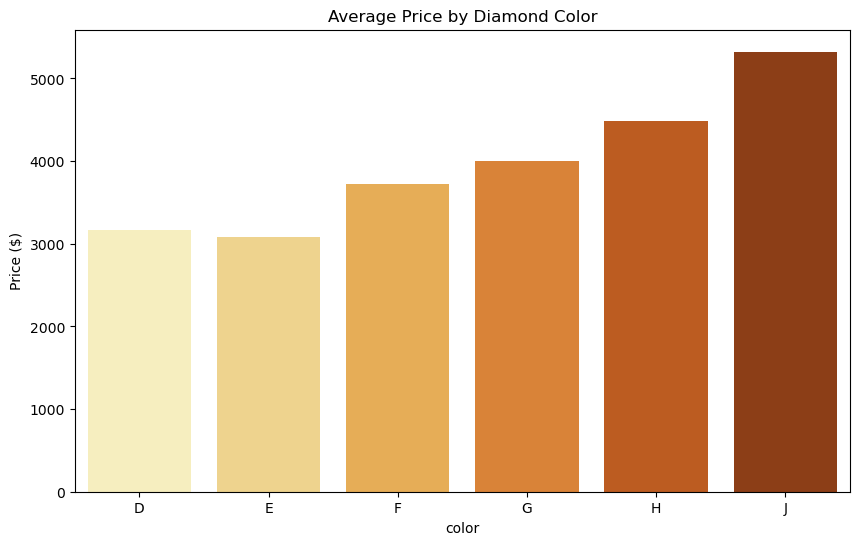

In [155]:
# Set the order of colors from D to J
color_order = ["D","E","F","G","H","J"]

# Create the barplot
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="color", y="price", 
            order=color_order, palette="YlOrBr", errorbar=None)

# Customize plot
plt.title("Average Price by Diamond Color")
plt.ylabel("Price ($)")
plt.show()

From the bar plot above, the prices for diamonds of colors `D` and `E` seem quite similar, but then the prices start to rise, increasing all the way through `J`. However, based on what we know about `color`, this may seem counterintuitive&mdash;why would a perfectly colorless diamond be worth less than a yellower one? We'll want to investigate further.

In [138]:
# Encode categorical variable
predictors = ["carat","color"]
Y = df["price"]
X = sm.add_constant(pd.get_dummies(df[predictors],
                        columns=["color"], drop_first=True, dtype=int))
model = sm.OLS(Y, X)
results = model.fit()

In [139]:
# Split data into X, Y train and X, Y test
X_test = X[:1000]   # for testing
Y_test = Y[:1000]   # for testing

X_train = X[1000:]  # for training
Y_train = Y[1000:]  # for training

In [159]:
model = sm.OLS(Y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 4.805e+04
Date:                Tue, 07 Oct 2025   Prob (F-statistic):               0.00
Time:                        00:26:18   Log-Likelihood:            -4.6119e+05
No. Observations:               52941   AIC:                         9.224e+05
Df Residuals:                   52933   BIC:                         9.225e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2136.8108     20.269   -105.421      0.0

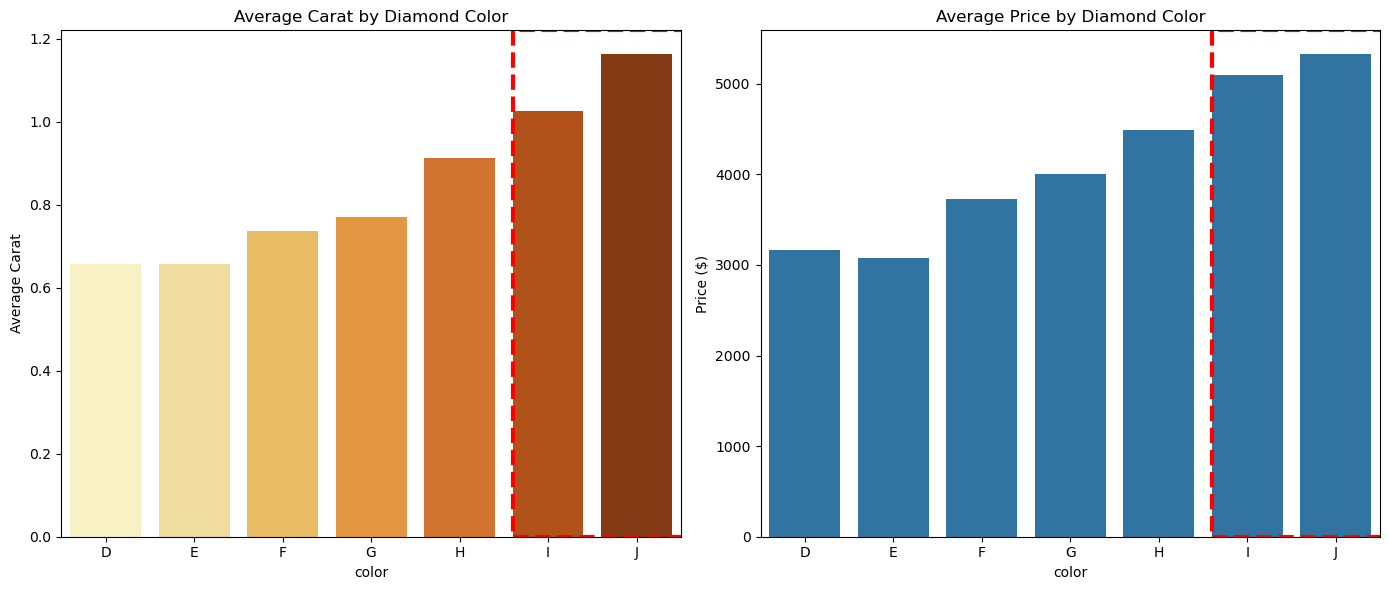

In [141]:
# Set the order of colors
color_order = ["D", "E", "F", "G", "H", "I", "J"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Barplot of Average Carat by Diamond Color
sns.barplot(data=df, x="color", y="carat", 
            order=color_order, palette="YlOrBr", errorbar=None, ax=axes[0])
axes[0].set_title("Average Carat by Diamond Color")
axes[0].set_ylabel("Average Carat")

# Barplot of Average Price by Diamond Color
sns.barplot(data=df, x="color", y="price", 
            order=color_order, color="C0", errorbar=None, ax=axes[1])
axes[1].set_title("Average Price by Diamond Color")
axes[1].set_ylabel("Price ($)")

# Annotate I and J bars in both plots
for ax in axes:
    rect = patches.Rectangle(
        (5 - 0.4, 0),      # x = index of 'I' - width/2
        2,                 # width = 2 bars ('I' and 'J')
        ax.get_ylim()[1],  # height = full height of y-axis
        linewidth=3,
        edgecolor='red',
        linestyle='--',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

**Results summary:**

+ These regression results help explain an interesting and somewhat surprising pattern in the data. From the `R-squared` value (0.864), the model improved by about `1.5%` compared to the previous one. Again, looking at the `p-values` for each coefficient, they all appear significant.

+ The coefficient for `carat` increased, and it's now about `$8,000` per `carat`, all else being equal. Interpreting the coefficients for these dummy variables can get tricky, as the coefficient for each `color` category is expressed relative to the `D` `color` diamonds which was dropped from the model. For example, `E color` diamonds are about `$94` less expensive on average, holding other factors constant. Compared to `D color` diamonds, `I color` diamonds are about `$1,054` less expensive, all else being constant.

+ These coefficients are all negative because, on average, `D color` diamonds are the most expensive&mdash;assuming the same `carat` weight. Looking again at the bar graph of _**`Average Price by Diamond Color`**_, it initially appeared like `I` and `J` `color` diamonds are worth more just because of their `color`. However, a more likely explanation is that diamonds with less desirable `color` tend to be larger in size. So, they have higher prices on average&mdash;not because of their `color`, but because of size. 

+ For two diamonds of the same `carat`, one with `color D` and one with `color J`, the `D color` diamond would be more valuable. The _**`Average Carat by Diamond Color`**_ bar plot above shows that diamond size tends to increase as `color` becomes yellower. This explanation matches our observations from the _**`Average Price by Clarity`**_ and _**`Average Carat by Clarity`**_ analyses.

### 5. Model Evaluation

Once a multiple linear regression model has been created, it has to be evaluated to determine how well it captures the relationships in the data. While the `R-squared` value provides an overall measure of fit, additional metrics and visualizations offer a more complete picture of model performance.

+ A good starting point is to _**`compare the model's predictions with the actual values.`**_ Plotting predicted versus actual in a scatterplot allows us to see how closely the predictions align with reality. This technique is particularly useful for multiple regression models since we can not simply look at a scatterplot between the independent and dependent variables and immediately assess the model's fit.

+ We can also _**`calculate a correlation between our predicted and actual values`**_ called _`multiple R`._ Multiple R, which ranges from 0 to 1, reflects the strength of the model's predictive power, and a higher value is better.
   
+ Another key step is to _**`calculate the residuals`**_ - the differences between actual price and predicted values. For instance, if a diamond's actual price is `$1,000` and the model predicts `$1,100`, the residual for is `-$100`, indicating that the model overpredicted the price. Conversely, if the model predicted `$900`, the residual would be positive `$100`. We can think of the residual as how much the model would need to adjust its prediction to be correct.

+ Finally, we can _**`calculate the Mean Absolute Error (MAE)`**_, which represents the average size of the errors in our predictions. MAE is in the same units as your data, in this case dollars, so it's highly interpretable.

In [175]:
# Use residuals to understand fit
y_pred = results.predict(X_test)
y_pred.head()

0    -376.053034
1    -537.354322
2    -376.053034
3    -852.813195
4   -1550.781485
dtype: float64

The first five predicted values are negative, which seems incorrect since diamond prices cannot be negative. However, we previously observed that the model performs poorly for smaller diamonds, so these results are consistent with that finding.

In [176]:
# First five actual prices
y_actual = Y_test
y_actual.head()

0    326
1    326
2    327
3    334
4    335
Name: price, dtype: int64

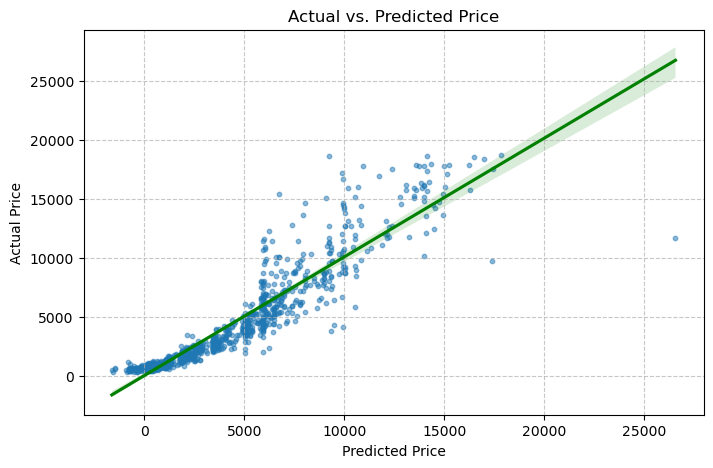

In [185]:
# Create a plot of predicted versus actual values
plt.figure(figsize=(8,5))
sns.regplot(
    x=y_pred, y=y_actual,
    scatter_kws={"s":10, "marker":"o", "alpha":0.5},
    line_kws={"color":"green"}
)

plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Actual vs. Predicted Price")
plt.grid(alpha=0.7, linestyle="--")

plt.show()

In an ideal situation, there would be a perfect positive correlation between the predicted and actual values. If the actual price were `$10,000`, the predicted value would also be `$10,000`. If this relationship were true, this graph would just be a perfect line at Y equals X.

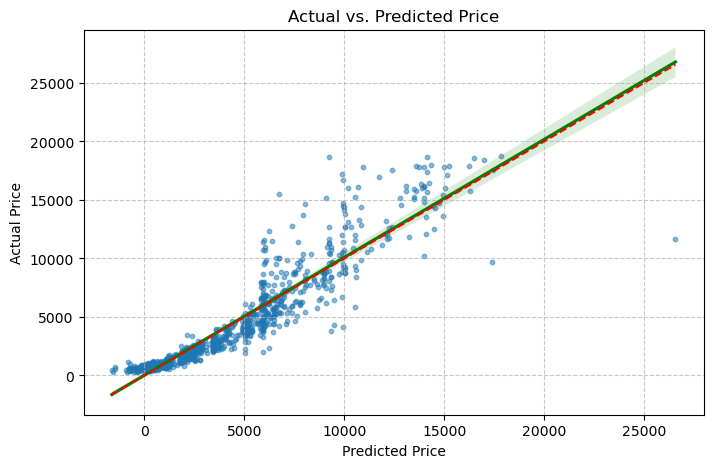

In [188]:
# Existing plot
plt.figure(figsize=(8,5))
sns.regplot(
    x=y_pred, y=y_actual,
    scatter_kws={"s":10, "marker":"o", "alpha":0.5},
    line_kws={"color":"green"}
)

plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Actual vs. Predicted Price")
plt.grid(alpha=0.7, linestyle="--")

# Adding the perfect y = x line
plt.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color="red", linestyle="--")

plt.show()

The red dashed line represents the ideal line where predicted prices would exactly match the actual prices (`Y = X`). This line is very close to the regression line&ndash;the model's line of best fit. However, there is a lot of deviation around it. 

The relationship between the predicted and actual values does not appear linear. There's a systematic deviation from this `Y = X` line: `low and very high actual prices tend to be underpredicted, appearing mostly above the ideal line. Mid-range prices are generally overpredicted, appearing mostly below the line.`

This nonlinearity suggests that the model might not fully capture the underlying relationship between the features and the target variable. Using a nonlinear model (such as polynomial regression, decision trees, or gradient boosting) could potentially yield better predictive performance.

We already know that the predicted and actual prices are highly correlated, but we can calculate Multiple R to quantify the strength of this relationship.

In [189]:
# Multiple R
y_pred.corr(y_actual)

0.9277629181426228

A value of around 0.93 suggests that, although the relationship is nonlinear, the predicted and actual values are still highly correlated. Next, we calculate the residuals with Y actual minus Y pred, which represent the differences between the actual and predicted prices.

In [190]:
residuals = y_actual - y_pred
residuals.head()

0     702.053034
1     863.354322
2     703.053034
3    1186.813195
4    1885.781485
dtype: float64

For the first diamond, the actual price was higher than the predicted price by about `$700`. Finally, we calculate the Mean Absolute Error using the residuals.

In [192]:
MAE = residuals.abs().mean()
print(MAE)

992.6128382942226


The predictions are, on average, off by about `$992`. Is that a lot? Well, `$1,000` might seem high, but it depends on the use case. Since this model is intended to serve as a starting point for a professional price estimation, this amount of error may be acceptable.

### 6. Conclusion

This project analyzed the key factors that influence diamond pricing and developed a predictive model using multiple linear regression. The model achieved an R-squared value of **0.86**, indicating that **86%** of the variation in diamond prices can be explained by the selected features &mdash; primarily `carat`, `cut`, `color`, `clarity` and `dimensions`. The correlation between predicted and actual prices (**~0.93**) further confirms that the model captures much of the underlying relationship in the data.

However, diagnostic plots and residual analysis revealed some systematic deviations from the ideal line, suggesting that the relationship between the predictors and price is not perfectly linear. In particular, the model tends to underpredict very small and very large diamonds while overpredicting mid-range prices. Despite this, the model provides reasonable performance as a baseline predictive tool. The **Mean Absolute Error** (MAE) of around `$992` suggests that, on average, predictions are within roughly `$1,000` of the true `price` &ndash; a margin acceptable for general pricing guidance but insufficient for high-precision valuation.

### 7. Recommendations and Business Application

While the multiple linear regression model performed well in explaining diamond `price` variation, several refinements could further enhance its accuracy and business applicability. The recommendations below focus on improving model performance, capturing more complex relationships, and expanding its real-world utility.

**1. Apply Nonlinear Transformation**

The current model assumes a linear relationship between predictors (such as `carat`, `clarity`, and `dimensions`) and `price`. However, diagnostic plots suggest that this assumption may not fully hold &ndash; particularly for very small and very large diamonds. To better capture the curved patterns observed in the data, nonlinear transformations (such as logarithmic or polynomial terms) can be applied to variables like `carat` and `price`.

**2. Incorporate Interaction Features**

Diamond value is rarely determined by a single attribute. The effect of one feature, such as `clarity`, may depend on another, such as `cut` or `color`. Introducing interaction terms (e.g.,`carat * cut` or `clarity * color`) would allow the model to account for these joint effects, improving both accuracy and interpretability.

**3. Explore Advanced Modeling Techniques**

Although multiple linear regression offers simplicity and interpretability, more advanced approaches such as Random Forests, Gradient Boosting, or Polynomial Regression could better capture nonlinear and interaction effects automatically. These methods can potentially lower prediction errors and increase generalizability.

In practice, this model can be integrated into a web-based pricing application using tools like Streamlit or Flask. Such an interface would enable:

   + Retailers to automatically estimate prices for new inventory
   + Appraisers and customers to verify pricing fairness, and 
   + Market analysts to monitor trends by diamond characteristics. 
   
Such deployment would make the model a data-driven pricing support tool, enhancing transparency, consistency, and efficiency across the diamond supply chain.